# Capston Project: Identify Arvato's Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data used has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [116]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

# magic word for producing visualizations in notebook
%matplotlib inline

### Data Exploration
There are four files associated with this project (not provided in this repo, due to usage terms agreement):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We use this information to cluster the general population into groups with similar demographic properties. Then, we see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [117]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [118]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()
azdias.describe()
azdias.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [119]:
feat_info.info()
feat_info.describe()
feat_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Data Cleaning

### 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### 1.1.1: Convert Missing Value Codes to NaNs

In [120]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_clean = azdias.copy()

#miss_list
for i in range(feat_info.attribute.count()):
    # parse the missing list string into an integer array
    miss_list = feat_info.missing_or_unknown[i][1:-1].split(',')
    if(len(miss_list[0]) > 0):
        for j in range(0, len(miss_list)): 
            if(pd.api.types.is_numeric_dtype(azdias_clean[feat_info.attribute[i]].dtype)):
                miss_list[j] = int(miss_list[j]) 

    # replace the missing values
    azdias_clean[feat_info.attribute[i]].replace(miss_list, np.nan, inplace=True)

In [121]:
azdias_clean.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AGER_TYP,NaN,NaN,NaN,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3


#### 1.1.2: Assess Missing Data in Each Column

In [122]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_clean.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

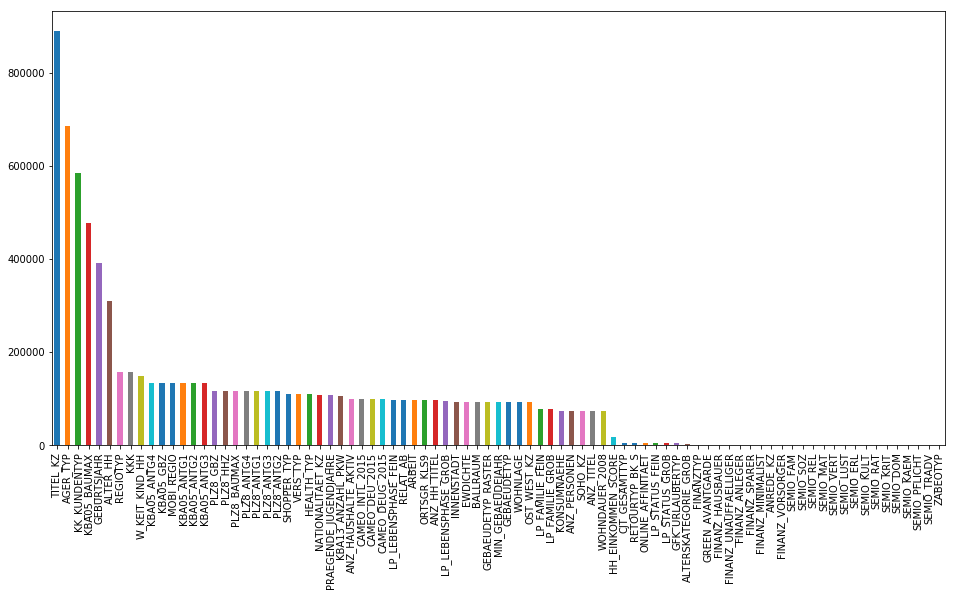

In [123]:
(azdias_clean.isnull().sum().sort_values(ascending=False)).plot.bar(figsize=(16,8))

In [124]:
# Investigate patterns in the amount of missing data in each column.
azdias_clean.isnull().sum().sort_values(ascending=False)/azdias_clean.shape[0]*100
print(np.mean([azdias_clean.isnull().sum()/azdias.shape[0]*100 > 33]))
print(np.sum([azdias_clean.isnull().sum()/azdias.shape[0]*100 > 33]))

0.0705882352941
6


In [125]:
drop_col = [(azdias_clean.isnull().sum()/azdias.shape[0]*100) > 30]

In [126]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# build the list of columns to be dropped
drop_col_list = []

for i in range(0, azdias_clean.shape[1]):
    if(drop_col[0][i]):
        drop_col_list.append(azdias_clean.columns[i])

# drop the columns from azdias dataset
azdias_clean.drop(drop_col_list, axis=1, inplace=True)

In [127]:
# drop the columns from the feat_info dataset
for i in drop_col_list:
    feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)

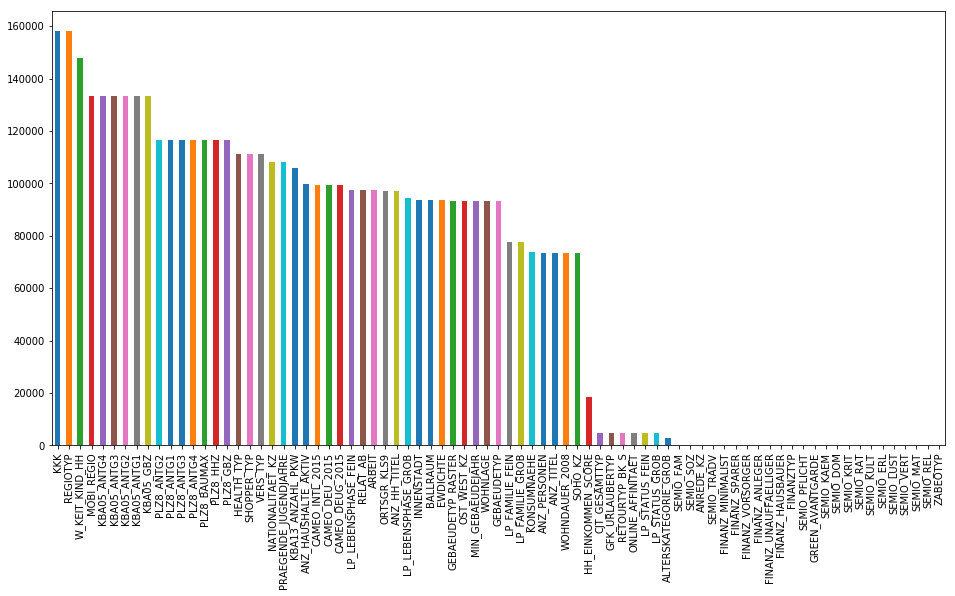

In [130]:
#azdias_clean.isnull().sum().sort_values(ascending=False)/azdias.shape[0]*100
(azdias_clean.isnull().sum().sort_values(ascending=False)).plot.bar(figsize=(16,8))

#### Discussion
We see that there are multiple columns with many missing records. To be specific, more than 54% of the columns are missing more than 10% of the values. However, dropping 54% of the dataset is not a good idea. So, we decided to drop columns with more than 20% missing values, which are only 6 columns (~6% of the total columns).

#### 1.1.3: Assess Missing Data in Each Row

Now we perform a similar assessment for the rows of the dataset. We divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold. In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.

In [131]:
# How much data is missing in each row of the dataset?
azdias_clean.isnull().mean(axis=1).sort_values(ascending=False)

643174    0.620253
732775    0.620253
472919    0.607595
183108    0.594937
139316    0.594937
691141    0.594937
691142    0.594937
691171    0.594937
691183    0.594937
139332    0.594937
691197    0.594937
139323    0.594937
691212    0.594937
691122    0.594937
139267    0.594937
139255    0.594937
139250    0.594937
139248    0.594937
139245    0.594937
139243    0.594937
691317    0.594937
691129    0.594937
691118    0.594937
139236    0.594937
139478    0.594937
690871    0.594937
690876    0.594937
690878    0.594937
690887    0.594937
139521    0.594937
            ...   
540246    0.000000
540244    0.000000
540243    0.000000
540242    0.000000
540241    0.000000
540240    0.000000
540239    0.000000
540269    0.000000
540271    0.000000
540300    0.000000
540289    0.000000
540299    0.000000
540298    0.000000
540296    0.000000
540295    0.000000
540293    0.000000
540292    0.000000
540291    0.000000
540290    0.000000
540287    0.000000
540273    0.000000
540286    0.

In [132]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 2/azdias_clean.shape[1]
azdias_incomp = azdias_clean[azdias_clean.isnull().mean(axis=1)>=threshold]
azdias_comp = azdias_clean[azdias_clean.isnull().mean(axis=1)<threshold]
print("azdias_clean  count = ", azdias_clean.shape[0])
print("azdias_incomp count = ", azdias_incomp.shape[0])
print("azdias_comp   count = ", azdias_comp.shape[0])
azdias_incomp.head(5).T

azdias_clean  count =  891221
azdias_incomp count =  252274
azdias_comp   count =  638947


,0,3,11,12,13
ALTERSKATEGORIE_GROB,2,4,2,3,1
ANREDE_KZ,1,2,1,1,2
CJT_GESAMTTYP,2,2,6,6,5
FINANZ_MINIMALIST,3,4,3,5,1
FINANZ_SPARER,4,2,4,3,4
FINANZ_VORSORGER,3,5,3,4,3
FINANZ_ANLEGER,5,2,5,2,5
FINANZ_UNAUFFAELLIGER,5,1,5,4,5
FINANZ_HAUSBAUER,3,2,3,1,2
FINANZTYP,4,6,4,3,1


In [133]:
azdias_clean.shape[1]

79

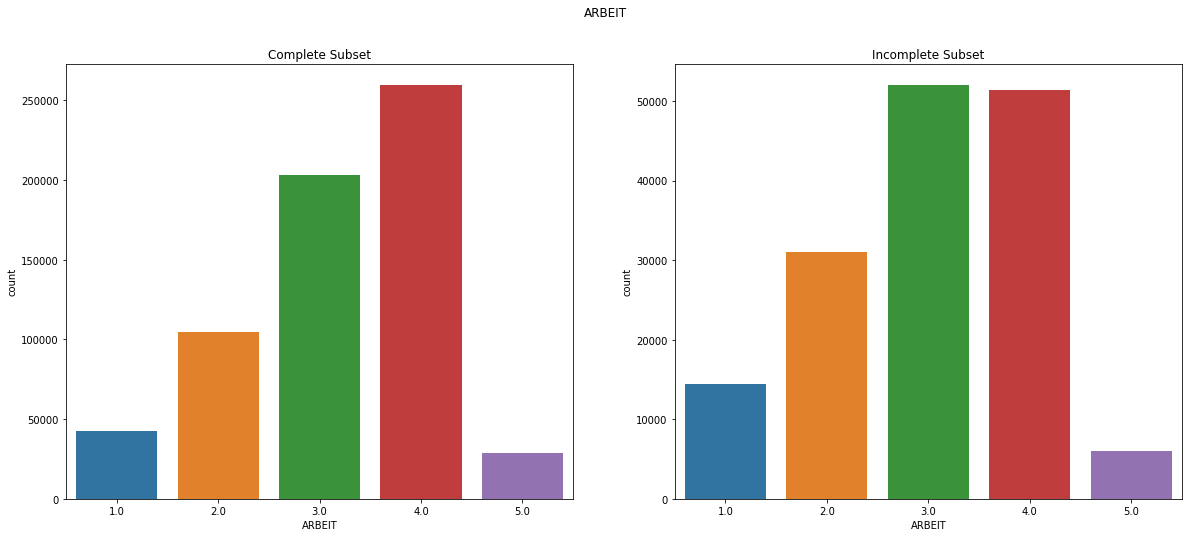

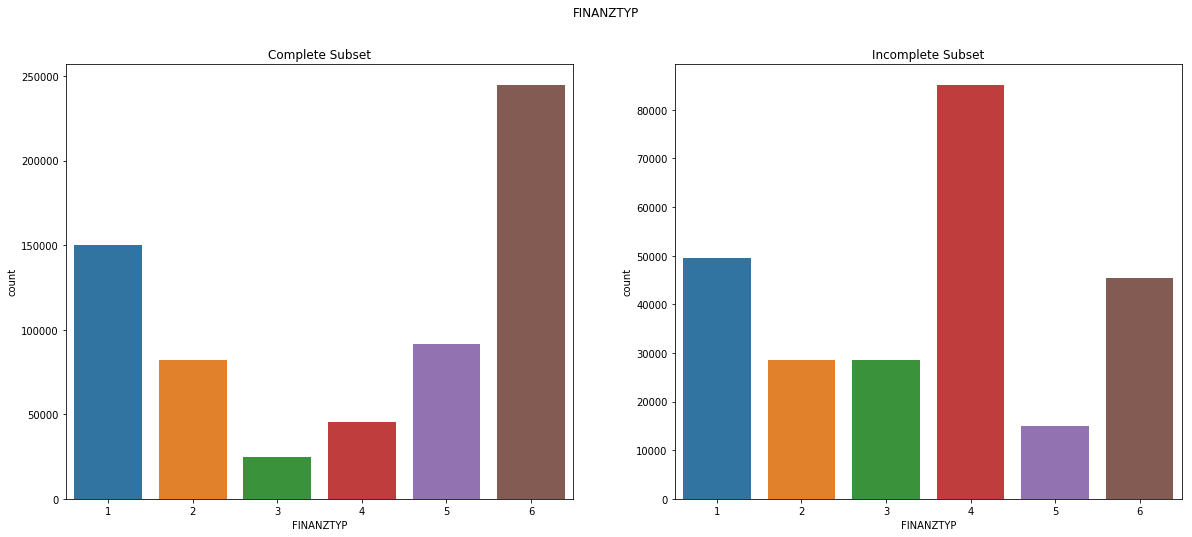

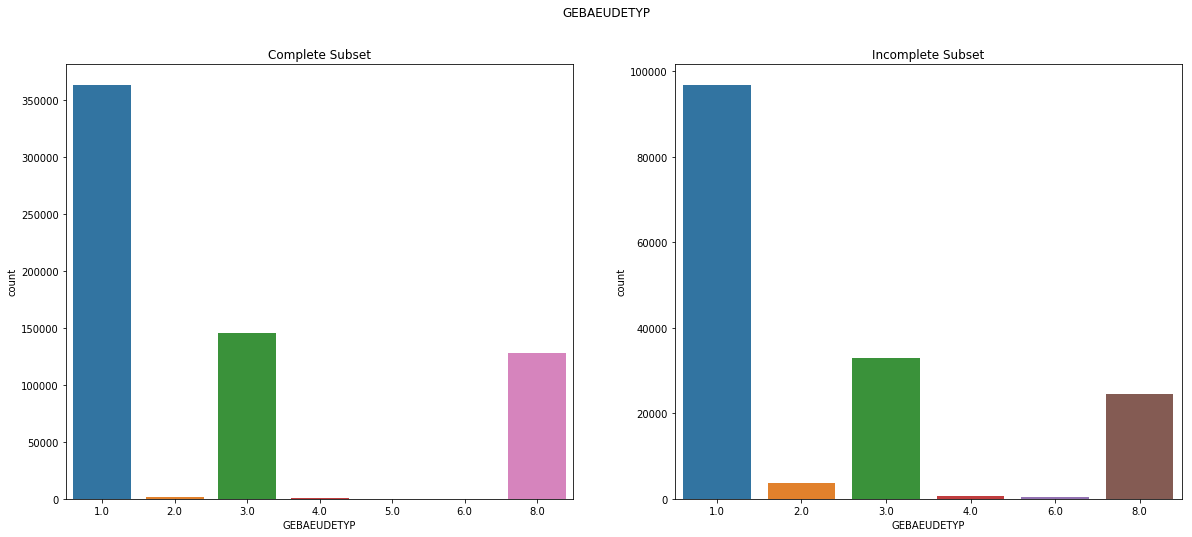

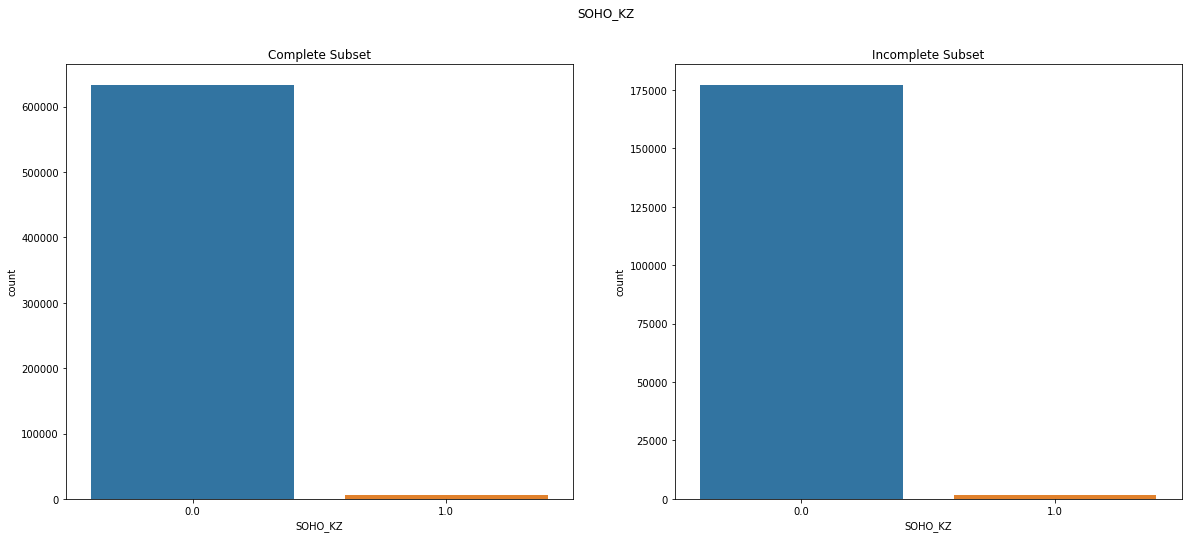

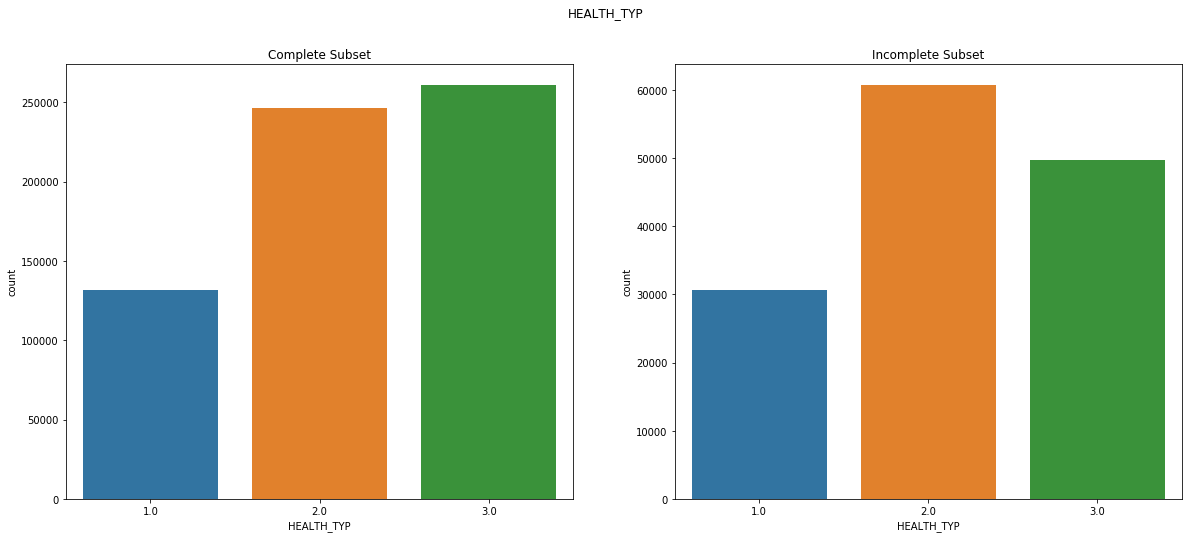

In [134]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def comp_col(df1, df2, col):
    f = plt.figure(figsize=(20, 8))
    #f, axes = plt.subplots(1, 2)
    axes = [0,1]
    axes[0] = f.add_subplot(121)
    axes[0].title.set_text('Complete Subset')
    sns.countplot(df1[col], ax=axes[0])
    
    axes[1] = f.add_subplot(122)
    axes[1].title.set_text('Incomplete Subset')
    sns.countplot(df2[col], ax=axes[1])
    f.suptitle(col)
    

# compare a random column set
num_cols = 5
cols = np.random.randint(azdias_clean.shape[1],size=num_cols)
for i in cols:
    comp_col(azdias_comp, azdias_incomp, azdias_clean.columns[i])


#### Discussion 1.1.3: Assess Missing Data in Each Row

We posed a thresold of a maximum of 2 missing values in each row to split the data into two sets. To compare the two sets, we randomly picked features from the 79 features in each set. We see that some features has similar distributions in both the two sets (e.g., LP_FAMILIE_GROB, PLZ8_ANTG1), while the distributions of other features express differences between the two sets (e.g., SEMIO_KULT). We will continue the analysis with the complete set, accepting to have a maximum of two missing values in each row.

### 1.2: Select and Re-Encode Features

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [135]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [136]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info['type']=='categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [137]:
# find binary and multi-valued categorical columns
for i in feat_info[feat_info['type']=='categorical'].attribute:
    print(i, "\t\t\t", azdias_comp[i].unique().size)

ANREDE_KZ 			 2
CJT_GESAMTTYP 			 6
FINANZTYP 			 6
GFK_URLAUBERTYP 			 12
GREEN_AVANTGARDE 			 2
LP_FAMILIE_FEIN 			 11
LP_FAMILIE_GROB 			 5
LP_STATUS_FEIN 			 10
LP_STATUS_GROB 			 5
NATIONALITAET_KZ 			 3
SHOPPER_TYP 			 4
SOHO_KZ 			 2
VERS_TYP 			 2
ZABEOTYP 			 6
GEBAEUDETYP 			 7
OST_WEST_KZ 			 2
CAMEO_DEUG_2015 			 9
CAMEO_DEU_2015 			 44


In [138]:
# For simplicity, drop the multi-level-valued categorical columns

# build the list of columns to be dropped
drop_col_list = []

for i in feat_info[feat_info['type']=='categorical'].attribute:
    if(azdias_comp[i].unique().size > 2):
        drop_col_list.append(i)

# drop the columns from azdias dataset
azdias_comp.drop(drop_col_list, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [139]:
# drop these multi-level-valued categorical columns from the feat_info dataset
for i in drop_col_list:
    feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)

In [140]:
# check the categorical columns again after dropping the multi-level-valued categorical columns
for i in feat_info[feat_info['type']=='categorical'].attribute:
    print(i, "\t\t\t", azdias_comp[i].unique().size)

ANREDE_KZ 			 2
GREEN_AVANTGARDE 			 2
SOHO_KZ 			 2
VERS_TYP 			 2
OST_WEST_KZ 			 2


In [141]:
# check the types of the columns
for i in feat_info[feat_info['type']=='categorical'].attribute:
    print(i, "\t", azdias_comp[i].dtype)

ANREDE_KZ 	 int64
GREEN_AVANTGARDE 	 int64
SOHO_KZ 	 float64
VERS_TYP 	 float64
OST_WEST_KZ 	 object


In [142]:
# We need to check only the OST_WEST_KZ column, as it is the only non-numeric column
azdias_comp['OST_WEST_KZ'].value_counts()


W    502748
O    136199
Name: OST_WEST_KZ, dtype: int64

In [143]:
# As the column has only two values, O and W, we can re-encode them with zero and one
azdias_comp['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [144]:
#check again
azdias_comp['OST_WEST_KZ'].value_counts()

1    502748
0    136199
Name: OST_WEST_KZ, dtype: int64

In [145]:
# check the types of the columns
for i in feat_info[feat_info['type']=='categorical'].attribute:
    print(i, "\t", azdias_comp[i].dtype)

ANREDE_KZ 	 int64
GREEN_AVANTGARDE 	 int64
SOHO_KZ 	 float64
VERS_TYP 	 float64
OST_WEST_KZ 	 int64


#### Discussion

The dataset has 18 categorical columns, of which 13 are multi-valued. For simplifying our work, we decided to drop all the multi-level valued columns. The remaining binary-valued columns are all of numerical type, except the OST_WEST_KZ column, which take on two values O and W. We re-encoded those values to 0 and 1, respectively. 

#### 1.2.2: Engineer Mixed-Type Features

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west).
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [146]:
# How many features are mixed
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [147]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables:
azdias_comp['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    148410
8.0     115728
5.0      70557
10.0     69539
3.0      44705
15.0     34196
9.0      29209
11.0     28707
6.0      23081
12.0     20195
4.0      18523
1.0      15607
2.0       6309
13.0      4494
7.0       3461
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [148]:
azdias_comp['PRAEGENDE_JUGENDJAHRE'].isnull().sum()

6226

In [149]:
azdias_comp['PRAEGENDE_JUGENDJAHRE'].mean()

9.2351036238721331

#### From the dictionary, we get this explanation of the values:
#### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

We see that the 'PRAEGENDE_JUGENDJAHRE' feature has two main feature combines, the youth generation and the movement orientation at that age (Avantgrade vs. Mainstream and east vs. west). The movement orientatin (Mainstream vs. Avantgrade) is more divisive than the direction (east vs. west) as some encodings has both (E+W). Thus, we will ignore the W/E information and focust only on the Mainstream vs. Avantgrade orientation, in addition to the youth generation years. 

Thus, we will re-engineer the feature into two features:

Youth_Years:
<li>1 $\rightarrow$ 40s
<li>2 $\rightarrow$ 50s
<li>3 $\rightarrow$ 60s
<li>4 $\rightarrow$ 70s
<li>5 $\rightarrow$ 80s
<li>6 $\rightarrow$ 90s
    
    
Movement_Orientation
<li>1 $\rightarrow$ Avantgrade
<li>2 $\rightarrow$ Mainstream

In [150]:
# Build the transformation dictionaries
youth_years = { 1: 1, 2: 1, 
                3: 2, 4: 2, 
                5: 3, 6: 3, 7: 3,
                8: 4, 9: 4, 
                10: 5, 11: 5, 12: 5, 13: 5,
                14: 6, 15: 6 }

move_orient = { 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1,
                1: 2, 3: 2, 5: 2, 8: 2, 10: 2, 12: 2, 14: 2 }


# Add the two columns replacing PRAEGENDE_JUGENDJAHRE
azdias_comp['YOUTH_YEARS'] = azdias_comp['PRAEGENDE_JUGENDJAHRE'].replace(youth_years)
azdias_comp['MOVE_ORIENT'] = azdias_comp['PRAEGENDE_JUGENDJAHRE'].replace(move_orient)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [151]:
#check the values
azdias_comp['YOUTH_YEARS'].value_counts()

6.0    182606
4.0    144937
5.0    122935
3.0     97099
2.0     63228
1.0     21916
Name: YOUTH_YEARS, dtype: int64

In [152]:
#check the nulls
azdias_comp['YOUTH_YEARS'].isnull().sum()

6226

In [153]:
#check the values
azdias_comp['MOVE_ORIENT'].value_counts()

2.0    484741
1.0    147980
Name: MOVE_ORIENT, dtype: int64

In [154]:
#check the nulls
azdias_comp['MOVE_ORIENT'].isnull().sum()

6226

In [155]:
# Now drop the PRAEGENDE_JUGENDJAHRE column
azdias_comp.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [156]:
# drop the PRAEGENDE_JUGENDJAHRE row from feat_info
feat_info.drop(feat_info[feat_info['attribute'] == 'PRAEGENDE_JUGENDJAHRE'].index, axis=0, inplace=True)

In [157]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_comp['CAMEO_INTL_2015'].value_counts()

51    114736
41     76608
24     75385
14     49195
43     47588
54     39345
25     31483
22     24326
45     22420
55     20049
13     19922
52     17097
34     15529
23     14926
15     13752
31     12673
44     12419
35      8631
32      8287
33      7575
12      7001
Name: CAMEO_INTL_2015, dtype: int64

#### From the dictionary, we get this explanation of the values:
#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [158]:
azdias_comp['CAMEO_INTL_2015'].isnull().sum()

0

In [159]:
azdias_comp['CAMEO_INTL_2015'].dtype

dtype('O')

In [160]:
azdias_comp['CAMEO_INTL_2015'].head(10)

1     51
2     24
4     43
5     54
6     22
7     14
8     13
9     15
10    51
19    34
Name: CAMEO_INTL_2015, dtype: object

From the above, we see that there are 5 classes of household wealth encoded in the first digit, and five classes of family types encoded in the second digit. Thus, we will break this column into two columns for wealth and family type, where each is filled by its respective digit.

Also, the column has no null values. There is one recored with one digit (5) (the first record). It is not apparent how to fill in the missing digit, thus we will drop that record.

In [161]:
# drop the record with value 5
id_to_drop = azdias_comp.head(1).index
azdias_comp.drop(id_to_drop, axis=0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [162]:
# Check again for the value counts
azdias_comp['CAMEO_INTL_2015'].value_counts()

51    114735
41     76608
24     75385
14     49195
43     47588
54     39345
25     31483
22     24326
45     22420
55     20049
13     19922
52     17097
34     15529
23     14926
15     13752
31     12673
44     12419
35      8631
32      8287
33      7575
12      7001
Name: CAMEO_INTL_2015, dtype: int64

In [163]:
def cameo_conveter(code, place):
    if(pd.notna(code)):
        return int(str(code)[place])

In [164]:
azdias_comp['WEALTH_LEVEL'] = azdias_comp['CAMEO_INTL_2015'].apply(cameo_conveter, place=0)
azdias_comp['FAMILY_STAGE'] = azdias_comp['CAMEO_INTL_2015'].apply(cameo_conveter, place=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [165]:
# Check if we did it right...
azdias_comp['CAMEO_INTL_2015'].head(10)

2     24
4     43
5     54
6     22
7     14
8     13
9     15
10    51
19    34
21    55
Name: CAMEO_INTL_2015, dtype: object

In [166]:
# WEALTH_LEVEL
azdias_comp['WEALTH_LEVEL'].head(10)

2     2
4     4
5     5
6     2
7     1
8     1
9     1
10    5
19    3
21    5
Name: WEALTH_LEVEL, dtype: int64

In [167]:
# FAMILY_STAGE
azdias_comp['FAMILY_STAGE'].head(10)

2     4
4     3
5     4
6     2
7     4
8     3
9     5
10    1
19    4
21    5
Name: FAMILY_STAGE, dtype: int64

In [168]:
azdias_comp['WEALTH_LEVEL'].isnull().sum()

0

In [169]:
azdias_comp['FAMILY_STAGE'].isnull().sum()

0

So it appears to be done right, so let us now drop the old column

In [170]:
# drop CAMEO_INTL_2015
azdias_comp.drop('CAMEO_INTL_2015', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [171]:
# drop the CAMEO_INTL_2015 row from feat_info
feat_info.drop(feat_info[feat_info['attribute'] == 'CAMEO_INTL_2015'].index, axis=0, inplace=True)

#### Other Mixed Type Features
Let't check on the other mixed type features

In [172]:
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
56,WOHNLAGE,building,mixed,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [173]:
print("Mixed Feature \t\t No. of Levels\n----------------------------------------")
for i in feat_info[feat_info.type == 'mixed'].attribute:
    print(i, "\t\t", azdias_comp[i].nunique())

Mixed Feature 		 No. of Levels
----------------------------------------
LP_LEBENSPHASE_FEIN 		 40
LP_LEBENSPHASE_GROB 		 12
WOHNLAGE 		 8
PLZ8_BAUMAX 		 5


We see that these features have several levels, and encoding them would greatly complicate the analysis at this initial exploration/clustering stage. So we decided to drop them for now.

In [174]:
for i in feat_info[feat_info.type == 'mixed'].attribute:
    # drop mixed feature from azdias df
    azdias_comp.drop(i, axis=1, inplace=True)
    
    # drop mixed features from feature information df
    feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion

There were 6 mixed type features. 
<li> LP_LEBENSPHASE_FEIN	
<li> LP_LEBENSPHASE_GROB	
<li> PRAEGENDE_JUGENDJAHRE
<li> WOHNLAGE	
<li> CAMEO_INTL_2015	
<li> PLZ8_BAUMAX	

We chose two to re-engineer, namely PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. Below are the details of our re-engineering:

#### PRAEGENDE_JUGENDJAHRE:
We see that the 'PRAEGENDE_JUGENDJAHRE' feature has two main feature combined, the youth generation and the movement orientation at that age (Avantgrade vs. Mainstream and east vs. west). The movement orientatin (Mainstream vs. Avantgrade) is more divisive than the direction (east vs. west) as some encodings has both (E+W). Thus, we will ignore the W/E information and focust only on the Mainstream vs. Avantgrade orientation, in addition to the youth generation years. Thus, we re-engineered the feature into two features, one with 6 levels, and the other with two levels (binary) as follows:

Youth_Years:
<li>1 $\rightarrow$ 40s
<li>2 $\rightarrow$ 50s
<li>3 $\rightarrow$ 60s
<li>4 $\rightarrow$ 70s
<li>5 $\rightarrow$ 80s
<li>6 $\rightarrow$ 90s
    
    
Movement_Orientation
<li>1 $\rightarrow$ Avantgrade
<li>2 $\rightarrow$ Mainstream
    
#### CAMEO_INTL_2015:
From the dictionary, we see that this feature shows the Wealth / Life Stage Typology, mapped to international code. Specifically, we see that this feature involves 5 classes of household wealth encoded in the first digit, and five classes of family types encoded in the second digit. Thus, we have broken this feature into two columns for wealth and family type, where each is filled by its respective digit.

Also, the column has no null values. There is one recored with one digit (5) (the first record). It is not apparent how to fill in the missing digit, thus we have dropped that record.


### The rest of the mixed-type features:
The other 4 mixed-type features have a total of 65 levels (combined), so adding them to the analysis at this stage would greatly complicate things, especially that this is the initial exploration/clustering pass. So we decided to drop them for now.

#### 1.2.3: Complete Feature Selection

A final check to make sure that your data frame only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [175]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_comp.shape


(638946, 64)

In [176]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638946 entries, 2 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     638946 non-null float64
ANREDE_KZ                638946 non-null int64
FINANZ_MINIMALIST        638946 non-null int64
FINANZ_SPARER            638946 non-null int64
FINANZ_VORSORGER         638946 non-null int64
FINANZ_ANLEGER           638946 non-null int64
FINANZ_UNAUFFAELLIGER    638946 non-null int64
FINANZ_HAUSBAUER         638946 non-null int64
GREEN_AVANTGARDE         638946 non-null int64
HEALTH_TYP               638946 non-null float64
RETOURTYP_BK_S           638946 non-null float64
SEMIO_SOZ                638946 non-null int64
SEMIO_FAM                638946 non-null int64
SEMIO_REL                638946 non-null int64
SEMIO_MAT                638946 non-null int64
SEMIO_VERT               638946 non-null int64
SEMIO_LUST               638946 non-null int64
SEMIO_ERL                638946 non-null int64
SEMIO_KULT               638946 non-n

We see that all the columns are of numeric type, and that all the re-engineered features are there, with their original features dropped out. 

### 1.3: Create a Cleaning Function

This function combine the above steps and can be run on that DataFrame to get the trimmed dataset in a single step.

In [177]:
def cameo_conveter(code, place):
    if(pd.notna(code)):
        return int(str(code)[place])

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    ########## convert missing value codes into NaNs, ...

    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
    df_c = df.copy()
    
    #miss_list
    for i in range(feat_info.attribute.count()):
    # parse the missing list string into an integer array
        miss_list = feat_info.missing_or_unknown[i][1:-1].split(',')
        if(len(miss_list[0]) > 0):
            for j in range(0, len(miss_list)): 
                if(pd.api.types.is_numeric_dtype(df[feat_info.attribute[i]].dtype)):
                    miss_list[j] = int(miss_list[j]) 

        # replace the missing values
        df_c[feat_info.attribute[i]].replace(miss_list, np.nan, inplace=True)

    ######### remove selected columns and rows, ...
    drop_col = [(df_c.isnull().sum()/df.shape[0]*100) > 33]
    
    # build the list of columns to be dropped
    drop_col_list = []

    for i in range(0, df_c.shape[1]):
        if(drop_col[0][i]):
            drop_col_list.append(df_c.columns[i])

    print(drop_col_list)
    # drop the columns from azdias dataset
    df_c.drop(drop_col_list, axis=1, inplace=True)

    # drop the columns from the feat_info dataset
    for i in drop_col_list:
        feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)
    
    # Drop rows with number of missing values greater than a threashold..
    threshold = 2/df_c.shape[1]
    df_c = df_c[df_c.isnull().mean(axis=1) < threshold]
    
    ######### select, re-encode, and engineer column values.

    # For simplicity, drop the multi-level-valued categorical columns

    # build the list of columns to be dropped
    drop_col_list = []
    
    for i in feat_info[feat_info['type']=='categorical'].attribute:
        if(df_c[i].unique().size > 2):
            drop_col_list.append(i)

    # drop the columns from azdias dataset
    df_c.drop(drop_col_list, axis=1, inplace=True)

    # drop these multi-level-valued categorical columns from the feat_info dataset
    for i in drop_col_list:
        feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)
    
        
    ## Clean the OST_WEST_KZ column (if exists)
    if 'OST_WEST_KZ' in df_c.columns:
        df_c['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)
    
    ## Clean the PRAEGENDE_JUGENDJAHRE column (if exists)
    
    if 'PRAEGENDE_JUGENDJAHRE' in df_c.columns:
        # Build the transformation dictionaries
        youth_years = { 1: 1, 2: 1, 
                        3: 2, 4: 2, 
                        5: 3, 6: 3, 7: 3,
                        8: 4, 9: 4, 
                        10: 5, 11: 5, 12: 5, 13: 5,
                        14: 6, 15: 6 }

        move_orient = { 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1,
                        1: 2, 3: 2, 5: 2, 8: 2, 10: 2, 12: 2, 14: 2 }


        # Add the two columns replacing PRAEGENDE_JUGENDJAHRE
        df_c['YOUTH_YEARS'] = df_c['PRAEGENDE_JUGENDJAHRE'].replace(youth_years)
        df_c['MOVE_ORIENT'] = df_c['PRAEGENDE_JUGENDJAHRE'].replace(move_orient)

        # Now drop the PRAEGENDE_JUGENDJAHRE column
        df_c.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

        # Then drop the PRAEGENDE_JUGENDJAHRE row from feat_info
        feat_info.drop(feat_info[feat_info['attribute'] == 'PRAEGENDE_JUGENDJAHRE'].index, axis=0, inplace=True)
    
    ## Clean the CAMEO_INTL_2015 column (if exists)
    
    # first incomplete record
    if 'CAMEO_INTL_2015' in df_c.columns:
        #id_to_drop = azdias_comp.head(1).index
        #df_c.drop(id_to_drop, axis=0, inplace=True)

        # replace the rest
        df_c['WEALTH_LEVEL'] = df_c['CAMEO_INTL_2015'].apply(cameo_conveter, place=0)
        df_c['FAMILY_STAGE'] = df_c['CAMEO_INTL_2015'].apply(cameo_conveter, place=1)

        # drop CAMEO_INTL_2015 from df and feat_info
        df_c.drop('CAMEO_INTL_2015', axis=1, inplace=True)
        feat_info.drop(feat_info[feat_info['attribute'] == 'CAMEO_INTL_2015'].index, axis=0, inplace=True)
        
    # drop the mixed-valued features
    for i in feat_info[feat_info.type == 'mixed'].attribute:
        # drop mixed feature from azdias df
        df_c.drop(i, axis=1, inplace=True)
    
        # drop mixed features from feature information df
        feat_info.drop(feat_info[feat_info['attribute'] == i].index, axis=0, inplace=True)
    
    ####### Return the cleaned dataframe.
    return df_c

## 2: Feature Transformation

### 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [178]:
azdias_comp.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_YEARS,MOVE_ORIENT,WEALTH_LEVEL,FAMILY_STAGE
count,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,...,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,638946.000000,632720.000000,632720.000000,638946.000000,638946.000000
mean,2.800899,1.512289,3.051721,2.669321,3.462012,2.764874,2.557977,3.190425,0.231600,2.202341,...,0.721509,3.615949,3.347626,3.201263,5.398196,3.115525,4.314265,1.766121,3.337473,2.874481
std,1.031078,0.499849,1.359564,1.474281,1.388721,1.453881,1.373783,1.369097,0.421855,0.757468,...,0.732199,0.961151,1.113799,0.988496,2.295675,1.350506,1.454261,0.423297,1.457208,1.501197
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000,3.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,5.000000,3.000000,4.000000,2.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,6.000000,2.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000,6.000000,2.000000,5.000000,5.000000


In [179]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# what is the percentage of missing data in the dataset
azdias_comp.isnull().sum().sum()/azdias_comp.count().sum()*100

0.053737919703172314

In [180]:
# How much per each column?
for i in range(0,azdias_comp.shape[1]):
    if(azdias_comp[azdias_comp.columns[i]].isnull().sum() > 0):
        print(azdias_comp.columns[i], "\t", 
              round(azdias_comp[azdias_comp.columns[i]].isnull().sum()/azdias_comp[azdias_comp.columns[i]].count()*100,2), "%")

W_KEIT_KIND_HH 	 1.15 %
ANZ_HAUSHALTE_AKTIV 	 0.27 %
KONSUMNAEHE 	 0.0 %
KBA13_ANZAHL_PKW 	 0.08 %
YOUTH_YEARS 	 0.98 %
MOVE_ORIENT 	 0.98 %


We see that the missing values are very small proportion of the total dataset (and at max 1.15% of a single column). Thus, we decide to drop them.

In [181]:
azdias_full = azdias_comp.dropna(axis=0)

In [182]:
azdias_full.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_YEARS,MOVE_ORIENT,WEALTH_LEVEL,FAMILY_STAGE
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,2.792540,1.511211,3.057799,2.677009,3.451434,2.770214,2.563092,3.169593,0.234626,2.207486,...,0.718528,3.614710,3.350438,3.199005,5.394506,3.113071,4.309748,1.765374,3.326598,2.875794
std,1.026485,0.499875,1.360773,1.469260,1.388873,1.448795,1.372307,1.365481,0.423765,0.758644,...,0.731721,0.960937,1.113337,0.989196,2.295722,1.351073,1.451538,0.423765,1.457814,1.499303
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000,3.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,5.000000,3.000000,4.000000,2.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,6.000000,2.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000,6.000000,2.000000,5.000000,5.000000


In [186]:
# Apply feature scaling to the general population demographics data.

#Create a standard scaler
scaler = StandardScaler()
scaler.fit(azdias_full)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [187]:
azdias_scale = scaler.transform(azdias_full)
azdias_scale

array([[ 0.20210748,  0.97782476, -1.51222884, ..., -1.80612936,
        -0.90999207,  0.74981921],
       [ 0.20210748, -1.02267813,  0.69240145, ...,  0.5536702 ,
         0.46192597,  0.08284223],
       [-1.7462911 ,  0.97782476, -0.04247531, ...,  0.5536702 ,
         1.14788499,  0.74981921],
       ..., 
       [-0.77209181,  0.97782476, -1.51222884, ...,  0.5536702 ,
        -0.22403305, -1.25111175],
       [-1.7462911 , -1.02267813, -1.51222884, ...,  0.5536702 ,
         1.14788499, -1.25111175],
       [ 1.17630677, -1.02267813,  0.69240145, ...,  0.5536702 ,
         0.46192597,  0.08284223]])

In [188]:
# Convert to a dataframe object
azdias_scale = pd.DataFrame(azdias_scale, columns=azdias_comp.columns)

In [189]:
# Re-check the percentage of missing data in the final dataset
azdias_scale.isnull().sum().sum()/azdias_full.count().sum()*100

0.0

In [190]:
# Check the statistics of the final scaled dataset
azdias_scale.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_YEARS,MOVE_ORIENT,WEALTH_LEVEL,FAMILY_STAGE
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05
mean,9.230537e-17,-2.194761e-17,-1.235907e-17,-1.291204e-17,8.812678e-17,-6.406137e-17,-5.717495e-17,3.927767e-18,8.841751e-18,-2.011427e-16,...,3.371523e-17,2.207074e-16,-1.265550e-18,6.943425e-17,-1.578076e-16,1.083756e-16,2.517647e-16,1.543658e-16,-1.723030e-16,-1.363802e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746291e+00,-1.022678e+00,-1.512229e+00,-1.141398e+00,-1.765054e+00,-1.221853e+00,-1.139026e+00,-1.588887e+00,-5.536702e-01,-1.591638e+00,...,-9.819705e-01,-2.721004e+00,-2.111167e+00,-2.223024e+00,-1.914217e+00,-1.563996e+00,-2.280168e+00,-1.806129e+00,-1.595951e+00,-1.251112e+00
25%,-7.720918e-01,-1.022678e+00,-7.773521e-01,-1.141398e+00,-1.045046e+00,-1.221853e+00,-1.139026e+00,-8.565436e-01,-5.536702e-01,-2.734958e-01,...,-9.819705e-01,-6.396996e-01,-3.147638e-01,-2.011791e-01,-6.074376e-01,-8.238429e-01,-9.023181e-01,5.536702e-01,-9.099921e-01,-1.251112e+00
50%,2.021075e-01,9.778248e-01,-4.247531e-02,2.198328e-01,3.949721e-01,1.586053e-01,-4.103255e-01,-1.242004e-01,-5.536702e-01,-2.734958e-01,...,3.846718e-01,-6.396996e-01,-3.147638e-01,-2.011791e-01,-1.718444e-01,-8.368999e-02,-2.133934e-01,5.536702e-01,4.619260e-01,8.284223e-02
75%,1.176307e+00,9.778248e-01,6.924015e-01,9.004483e-01,1.114981e+00,8.488345e-01,1.047076e+00,6.081428e-01,-5.536702e-01,1.044647e+00,...,3.846718e-01,4.009526e-01,5.834378e-01,8.097433e-01,6.993421e-01,6.564629e-01,1.164456e+00,5.536702e-01,1.147885e+00,7.498192e-01
max,1.176307e+00,9.778248e-01,1.427278e+00,1.581064e+00,1.114981e+00,1.539064e+00,1.775776e+00,1.340486e+00,1.806129e+00,1.044647e+00,...,1.751314e+00,1.441605e+00,1.481640e+00,1.820666e+00,1.570529e+00,1.396616e+00,1.164456e+00,5.536702e-01,1.147885e+00,1.416796e+00


### 2.1: Apply Feature Scaling

We explored the amount of missing data in the dataset, which appears to be about 0.56% of the total. We have considered this as a very small portion that would have minimal impact on the distribution if dropped, as is evident from the statistics summaries of the dataset before and after dropping the missing values. Thus, we proceeded by dropping the missing values and performing the scaling with the remaining records, without the need to do any imputation.

### 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

In [191]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_scale)

Text(0.5,1,'Explained Variance Ratio vs. No. of Principal Components')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


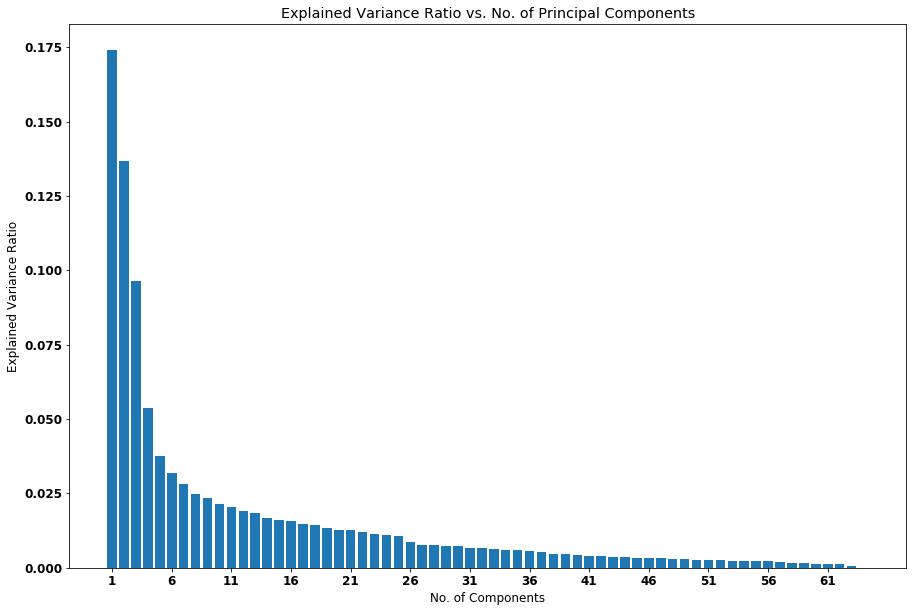

In [213]:
# Investigate the variance accounted for by each principal component.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

n_comp = azdias_pca.singular_values_.size
ratio  = azdias_pca.explained_variance_ratio_
f = plt.figure(figsize=(15, 10))
plt.bar(np.arange(1,n_comp+1), ratio)
plt.xticks(np.arange(1,n_comp+1, 5));
plt.xlabel('No. of Components');
plt.ylabel('Explained Variance Ratio');
plt.title('Explained Variance Ratio vs. No. of Principal Components')

[]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


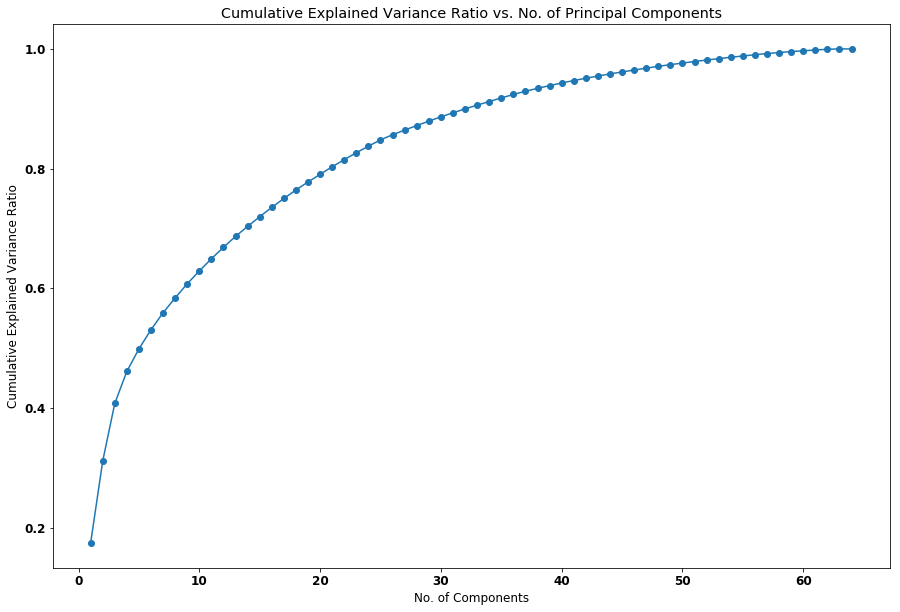

In [217]:
#plot the cumulative sum of explained variance by PCA components
f = plt.figure(figsize=(15, 10))
plt.plot(np.arange(1,n_comp+1), np.cumsum(ratio), '-o');
plt.xlabel('No. of Components');
plt.ylabel('Cumulative Explained Variance Ratio');
plt.title('Cumulative Explained Variance Ratio vs. No. of Principal Components')
plt.plot()

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_25 = PCA(n_components=25)
azdias_pca_25 = pca_25.fit_transform(azdias_scale)

### Discussion 
We have performed PCA using all components, and plotted the ratio explained by each component. As expected, the explained variance decays moving forward from the first component to the last. We are interested in getting more than 75% of the variance captured, and as we see that this is captured between 20-30 components. As a sharper dipping point in explained variance is seen between the 25th and 26th components, we decided to cut off the components there as the rest of the components already have a deminishing variance value to explain.

### 2.3: Interpret Principal Components

Now we check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [218]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_comp_weighted_features(df, pca, c_no):
    pca_df = pd.DataFrame(pca.components_, columns=df.keys())
    c_all = pca_df.iloc[c_no - 1, :].sort_values(ascending=False)
    c_positive = c_all[c_all > 0].sort_values(ascending=False)
    c_negative = c_all[c_all < 0].sort_values(ascending=True)

    return c_all, c_negative, c_positive

def plot(c_n, c_p, n_f, c_no):
    f = plt.figure(figsize=(15, 5))
    #sns.set(font_scale=2)
    #f.subplots_adjust(hspace=5)
    axes = [0,1]
    axes[0] = f.add_subplot(121)
    axes[0].title.set_text('Negative Weights')
    sns.barplot(y = c_n.keys()[:n_f], x=c_n.values[:n_f], ax=axes[0])

    axes[1] = f.add_subplot(122)
    axes[1].title.set_text('Positive Weights')
    sns.barplot(y = c_p.keys()[:n_f], x=c_p.values[:n_f], ax=axes[1])
    axes[1].yaxis.tick_right()

    title = "Top " + str(n_f) + " Features (Positive and Negative) for Component " + str(c_no)
    
    f.suptitle(title)

In [220]:
# Map weights for the first principal component to corresponding feature names
c_all_1, c_pos_1, c_neg_1 = pca_comp_weighted_features(azdias_scale, pca_25, 1)
c_all_1

PLZ8_ANTG3               0.213718
PLZ8_ANTG4               0.207552
WEALTH_LEVEL             0.197156
HH_EINKOMMEN_SCORE       0.195056
ORTSGR_KLS9              0.184227
EWDICHTE                 0.181221
FINANZ_SPARER            0.165813
KBA05_ANTG4              0.146316
FINANZ_HAUSBAUER         0.144909
PLZ8_ANTG2               0.141631
ARBEIT                   0.137236
SEMIO_PFLICHT            0.134192
SEMIO_REL                0.131590
KBA05_ANTG3              0.131533
ANZ_HAUSHALTE_AKTIV      0.130112
YOUTH_YEARS              0.126724
RELAT_AB                 0.124980
SEMIO_TRADV              0.120264
MOVE_ORIENT              0.115301
SEMIO_RAT                0.110210
SEMIO_MAT                0.097791
FINANZ_UNAUFFAELLIGER    0.094740
SEMIO_FAM                0.094596
SEMIO_KULT               0.092753
FINANZ_ANLEGER           0.087289
REGIOTYP                 0.072320
SEMIO_SOZ                0.052667
KKK                      0.045746
HEALTH_TYP               0.038561
PLZ8_HHZ      

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


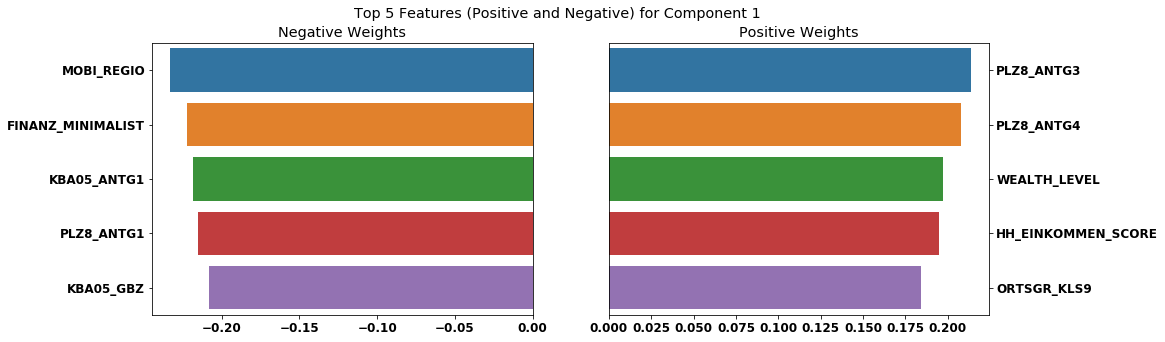

In [221]:
plot(c_pos_1, c_neg_1, 5, 1)

In [222]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
c_all_2, c_pos_2, c_neg_2 = pca_comp_weighted_features(azdias_scale, pca_25, 2)
c_all_2

ALTERSKATEGORIE_GROB     0.245188
SEMIO_ERL                0.224266
FINANZ_VORSORGER         0.213829
SEMIO_LUST               0.169072
RETOURTYP_BK_S           0.161124
FINANZ_HAUSBAUER         0.130939
SEMIO_KRIT               0.122087
W_KEIT_KIND_HH           0.119924
PLZ8_ANTG3               0.117821
SEMIO_KAEM               0.115434
PLZ8_ANTG4               0.112916
EWDICHTE                 0.110804
ORTSGR_KLS9              0.110597
WEALTH_LEVEL             0.092700
ANREDE_KZ                0.090217
ARBEIT                   0.083184
KBA05_ANTG4              0.082805
PLZ8_ANTG2               0.077959
RELAT_AB                 0.077828
ANZ_HAUSHALTE_AKTIV      0.073376
SEMIO_DOM                0.070565
HH_EINKOMMEN_SCORE       0.068500
KBA05_ANTG3              0.062074
WOHNDAUER_2008           0.052495
FINANZ_MINIMALIST        0.040816
ANZ_HH_TITEL             0.032877
REGIOTYP                 0.031266
MOVE_ORIENT              0.030862
VERS_TYP                 0.029860
PLZ8_HHZ      

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


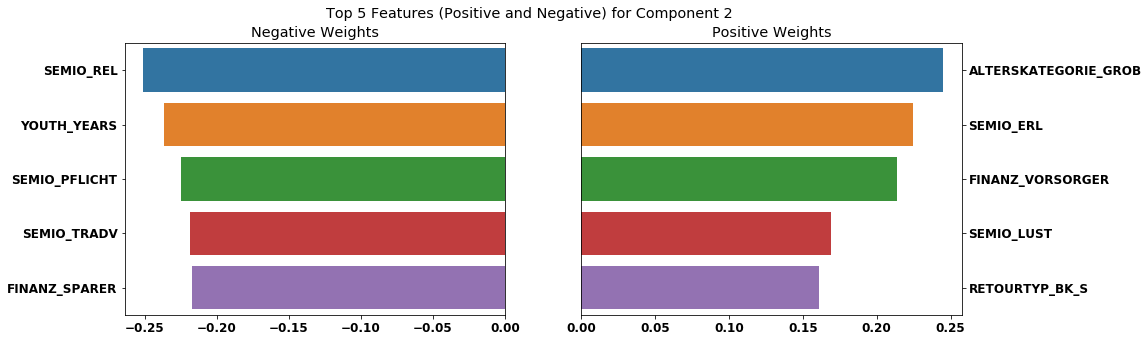

In [223]:
plot(c_pos_2, c_neg_2, 5, 2)

In [224]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
c_all_3, c_pos_3, c_neg_3 = pca_comp_weighted_features(azdias_scale, pca_25, 3)
c_all_3

SEMIO_VERT               0.348014
SEMIO_SOZ                0.263596
SEMIO_FAM                0.251412
SEMIO_KULT               0.231455
FINANZ_MINIMALIST        0.156671
RETOURTYP_BK_S           0.116013
FINANZ_VORSORGER         0.098249
W_KEIT_KIND_HH           0.094845
ALTERSKATEGORIE_GROB     0.082356
SEMIO_REL                0.076438
SEMIO_LUST               0.073297
GREEN_AVANTGARDE         0.050848
EWDICHTE                 0.049057
ORTSGR_KLS9              0.048821
SEMIO_MAT                0.048767
PLZ8_ANTG4               0.046399
PLZ8_ANTG3               0.045843
WOHNDAUER_2008           0.034885
ARBEIT                   0.033021
RELAT_AB                 0.031363
PLZ8_ANTG2               0.030337
KBA05_ANTG4              0.029295
ANZ_HAUSHALTE_AKTIV      0.026813
WEALTH_LEVEL             0.024853
VERS_TYP                 0.020775
ANZ_HH_TITEL             0.014529
ANZ_TITEL                0.010450
KBA05_ANTG3              0.007143
PLZ8_HHZ                 0.006608
SOHO_KZ       

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


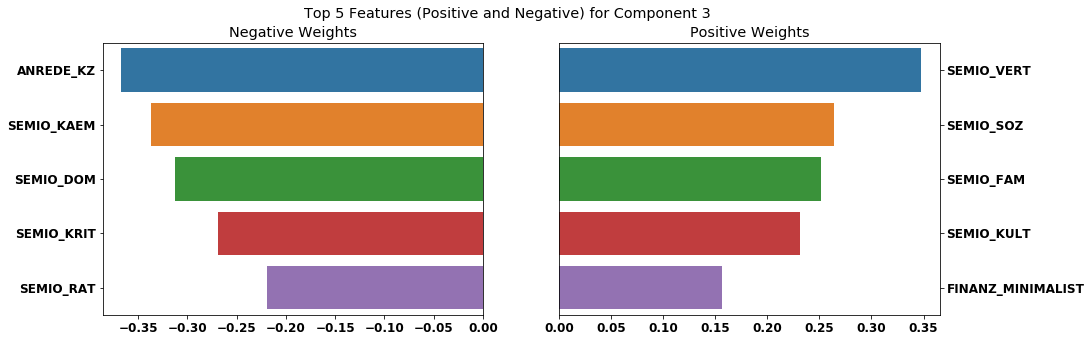

In [225]:
plot(c_pos_3, c_neg_3, 5, 3)

### Discussion 

We see that there are multiple features that are directly proportional to each other. For example:

<li> In <b>component 1</b>, <b>KBA05_ANTG1</b> and <b>KBA05_GBZ</b> are directly proportional. They represent the number of 1-2 families in the microcell and the number of building in the microcell. Naturally, this should be the case (as the number of families increases, the number of buildings should increase, too.
    
<li> Another example from <b>component 1</b> is <b>PLZ8_ANTG1</b>, <b>PLZ8_ANTG3</b> and <b>PLZ8_ANTG4</b>, which represent the number of 1-2, 6-10, and 10+ family houses in the PLZ8 region, respectively. Clearly the latter 2 are directly proportional (as they are closer in size to each other). In addition, the latter two are reversly proportional to the first (<b>PLZ8_ANTG1</b>), as they differ in size by a large amount (1-2 families are much smaller than 6-10 and 10+ families
    
<li> Another example is from the third component, where <b>SEMIO_VERT</b> and <b>SEMIO_KRIT</b> are reversly proportional, as they represent two very different personality topologies: dreamful vs. critical, respectively.

## 3: Clustering

### 3.1: Apply Clustering to General Population

Now, it's time to see how the data clusters in the principal components space. We apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [227]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters = center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [228]:
# Over a number of different cluster counts, run k-means clustering on the data and...
# compute the average within-cluster distances.
   
scores = []
centers = list(range(1,20))

for center in centers:
    print(center)
    scores.append(get_kmeans_score(azdias_pca_25, center))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


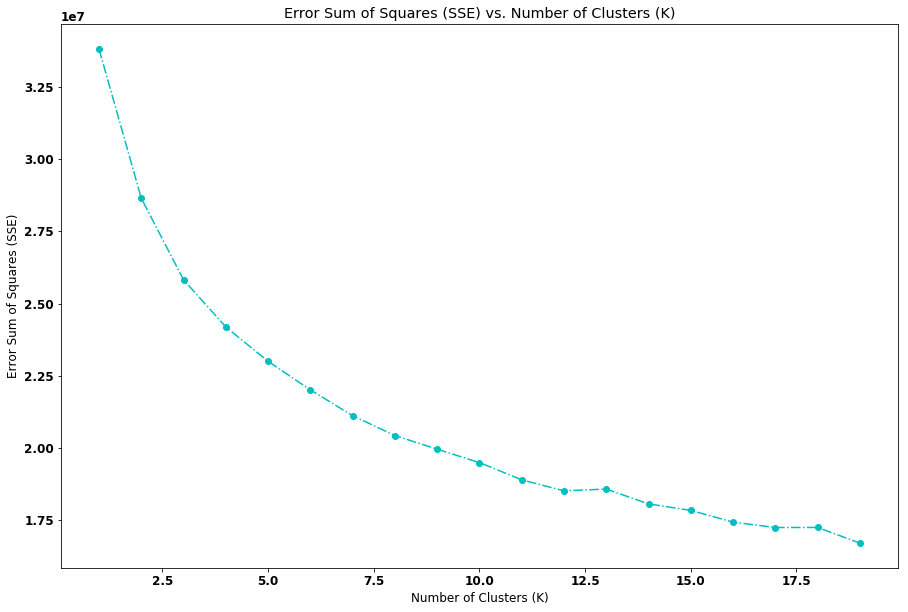

In [236]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
f = plt.figure(figsize=(15, 10))
plt.plot(centers, scores, linestyle='-.', marker='o', color='c');
plt.title('Error Sum of Squares (SSE) vs. Number of Clusters (K)');
plt.xlabel('Number of Clusters (K)');
plt.ylabel('Error Sum of Squares (SSE)');

In [237]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 10
kmeans = KMeans(n_clusters=k, n_jobs=-1)
clustering_model = kmeans.fit(azdias_pca_25)
azdias_clusters = clustering_model.predict(azdias_pca_25)

### Discussion
After plotting the clustering scores for 2-30 clusters, and comparing that score using the elbow method, we decided to chose 10 clusters, as that seems to be the number of clusters about which the clustering score flattens out.

### 3.2: Apply All Steps to the Customer Data

Now we see how the customer data maps on to those clusters.

In [238]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS.csv', sep=';')
customers.shape

(191652, 85)

In [239]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [240]:
customers_clean.shape

(116609, 64)

In [241]:
# How much data is missing 
customers_clean.isnull().sum().sum()/customers.count().sum()*100

0.0091180131621369388

In [242]:
# How much per each column?
for i in range(0,customers_clean.shape[1]):
    if(customers_clean[customers_clean.columns[i]].isnull().sum() > 0):
        print(customers_clean.columns[i], "\t", 
              round(customers_clean[customers_clean.columns[i]].isnull().sum()/customers_clean[customers_clean.columns[i]].count()*100,2), "%")

W_KEIT_KIND_HH 	 0.43 %
ANZ_HAUSHALTE_AKTIV 	 0.1 %
KONSUMNAEHE 	 0.0 %
KBA05_GBZ 	 0.0 %
KBA13_ANZAHL_PKW 	 0.03 %
YOUTH_YEARS 	 0.27 %
MOVE_ORIENT 	 0.27 %


In [243]:
# drop the missing value records
customers_full = customers_clean.dropna(axis=0)

In [244]:
customers_full.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_YEARS,MOVE_ORIENT,WEALTH_LEVEL,FAMILY_STAGE
count,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,...,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000
mean,3.529154,1.323452,4.285171,1.395709,4.596353,1.551516,1.795448,2.769904,0.531628,1.954074,...,0.543388,3.631884,3.611641,2.836817,5.163244,2.921638,2.843354,1.468372,2.605865,3.396531
std,0.677143,0.467796,1.003081,0.797901,0.819966,0.959433,0.928984,1.291275,0.499001,0.765816,...,0.638228,0.924912,1.006694,1.005569,2.158596,1.420083,1.317281,0.499001,1.408235,1.336950
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,3.000000,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,3.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,3.000000,4.000000,3.000000,5.000000,3.000000,3.000000,1.000000,2.000000,4.000000
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.000000,3.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,4.000000,2.000000,4.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000,6.000000,2.000000,5.000000,5.000000


In [245]:
customers_full.isnull().sum().sum()

0

In [246]:
# scale customer data
customers_scale = scaler.transform(customers_full)

In [247]:
# Reduce the order of the data by performing PCA with 25 components
customers_pca_25 = pca_25.fit_transform(customers_scale)

In [248]:
# Perform the clustering
customers_clusters = clustering_model.predict(customers_pca_25)

### 3.3: Compare Customer Data to Demographics Data

Here we will compare the two cluster distributions to see where the strongest customer base for the company is.

Text(0.5,0.98,'Comparison between Clusters of the General Population and Customers Population')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['small'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


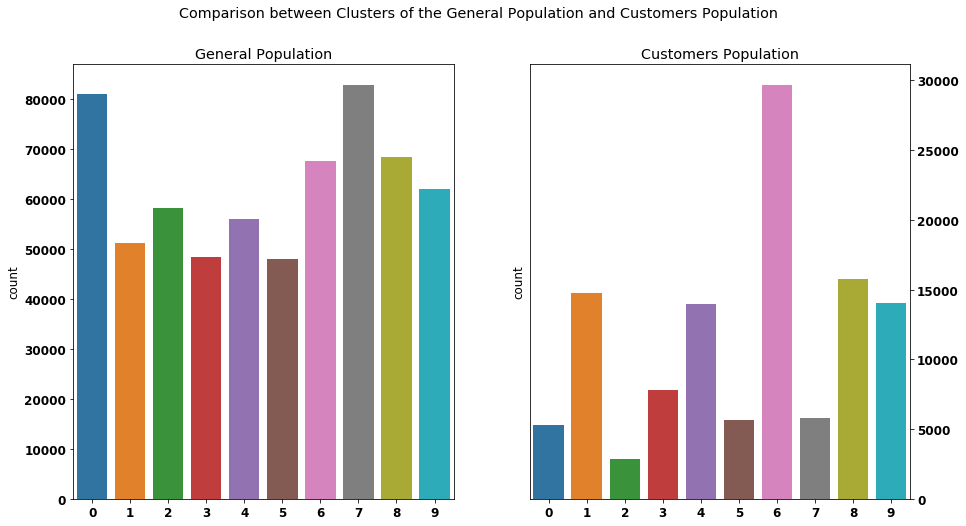

In [255]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

f = plt.figure(figsize=(15, 8))
#sns.set(font_scale=2)
#f.subplots_adjust(hspace=5)
axes = [0,1]
axes[0] = f.add_subplot(121)
axes[0].title.set_text('General Population')
sns.countplot(azdias_clusters, ax=axes[0])

axes[1] = f.add_subplot(122)
axes[1].title.set_text('Customers Population')
sns.countplot(customers_clusters, ax=axes[1])
axes[1].yaxis.tick_right()

title = "Comparison between Clusters of the General Population and Customers Population"

f.suptitle(title)

In [251]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(pca_25.inverse_transform(clustering_model.cluster_centers_[0]))
overrep_0 = pd.Series(data = centroid_0, index = customers_full.columns)
overrep_0

ALTERSKATEGORIE_GROB        3.683408
ANREDE_KZ                   1.747418
FINANZ_MINIMALIST           3.873940
FINANZ_SPARER               1.299415
FINANZ_VORSORGER            4.702646
FINANZ_ANLEGER              1.635972
FINANZ_UNAUFFAELLIGER       1.683222
FINANZ_HAUSBAUER            3.332646
GREEN_AVANTGARDE            0.596111
HEALTH_TYP                  1.870981
RETOURTYP_BK_S              3.842372
SEMIO_SOZ                   3.286095
SEMIO_FAM                   2.675041
SEMIO_REL                   2.092670
SEMIO_MAT                   2.670568
SEMIO_VERT                  3.841822
SEMIO_LUST                  5.871288
SEMIO_ERL                   6.134553
SEMIO_KULT                  2.384492
SEMIO_RAT                   2.847791
SEMIO_KRIT                  5.168140
SEMIO_DOM                   5.052569
SEMIO_KAEM                  5.074024
SEMIO_PFLICHT               2.608555
SEMIO_TRADV                 2.339851
SOHO_KZ                     0.014110
VERS_TYP                    1.562612
A

In [252]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_6 = scaler.inverse_transform(pca_25.inverse_transform(clustering_model.cluster_centers_[6]))
underrep_6 = pd.Series(data = centroid_6, index = customers_full.columns)
underrep_6

ALTERSKATEGORIE_GROB        3.700038
ANREDE_KZ                   0.855299
FINANZ_MINIMALIST           5.337391
FINANZ_SPARER               1.084021
FINANZ_VORSORGER            4.834186
FINANZ_ANLEGER              0.900691
FINANZ_UNAUFFAELLIGER       1.760047
FINANZ_HAUSBAUER            1.796495
GREEN_AVANTGARDE            1.079202
HEALTH_TYP                  1.704548
RETOURTYP_BK_S              4.151986
SEMIO_SOZ                   5.704902
SEMIO_FAM                   4.931691
SEMIO_REL                   3.830057
SEMIO_MAT                   4.539374
SEMIO_VERT                  6.996998
SEMIO_LUST                  6.137086
SEMIO_ERL                   3.491911
SEMIO_KULT                  5.277724
SEMIO_RAT                   2.290305
SEMIO_KRIT                  2.341995
SEMIO_DOM                   2.790617
SEMIO_KAEM                  1.559593
SEMIO_PFLICHT               2.700554
SEMIO_TRADV                 3.045940
SOHO_KZ                    -0.003472
VERS_TYP                    1.250700
A

### Discussion

For the sake of this description/analysis of the overrepresented and underrepresented people in this customer dataset, we have picked two clusters: the most overrepresented cluster (cluster 0) and the most underrepresented cluster (cluster 6). From the above features of the two clusters, they look quite different in a number of ways. Some of these clear differences are:

<li> The average estimated household net income <b>HH_EINKOMMEN_SCORE</b> is quite different. It is more skewed to highest and very high net income (1.45) for the overreprsented people, while it tends to be more skewed towards the lower income classes (3.52) for the underrepresnted people.
    
<li> The above point is also supported by the engineered feature <b>WEALTH_LEVEL</b>, which tends to be higher average wealth level (1.53) for the overreprsented people, compared to the average wealth level of the underrepsented people (2.86).

<li> The average number of adults in the neighborhood <b>ANZ_PERSONEN</b> for the underrepresented cluster is 2.9, while it is only 1.8 for the underreprsented cluster. This is also inline with the above observations, as in general, richer neighborhoods tend to have less population concentrations.
    
<li> Finally, the average family stage <b>FAMILY_STAGE</b> for the overrepresnted people tend to be more skewed towrds older, more established, families (4.16), compared to the average family stage for the underrepresented people, which tends to be more skewed towards younger, more developing, families (3.08). This also agrees with the wealth-level and neighborhood richness indicators above.
    
    
From these observations, we can see that older, more established, families who have higher income and live in richer neighborhoods tend to be overrepresnted in Azdias customer base. More focused marketing strategies can be used to take advantage of the interese of this customer segment in their products.

On the other hand, younger, more developing families, with lesser income and who live in less wealthy neighborhoods are underrepresented in the customer base. This need to be investigated in more detail to understand why this segment is not interested in Azdias products.